In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("./preprocessed.csv")

df

,game_id,game_date,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,...,game_count,win_per,region,field_goal_per,three_point_per,free_throw_per,eFG%,FGA,pos,REB
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,14,7,7,18,0,0,18,...,28,0.678571,North,0.440000,0.454545,0.500000,0.440000,61,67.8144,36
1,game_2022_2011,2021-12-30,lsu_tigers,15,2,15,14,2,0,7,...,28,0.821429,North,0.480000,0.363636,0.533333,0.480000,61,67.7760,36
2,game_2022_2012,2021-12-30,missouri_tigers,10,1,4,8,1,0,11,...,30,0.600000,South,0.418605,0.466667,0.812500,0.418605,58,64.3584,37
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,15,8,3,8,0,0,15,...,31,0.935484,North,0.418182,0.285714,0.555556,0.418182,76,65.2416,47
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,16,8,5,15,1,0,13,...,31,0.741935,North,0.487805,0.266667,0.666667,0.487805,56,62.9760,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,15,3,4,10,0,0,12,...,30,0.300000,NaN,0.431818,0.166667,0.750000,0.431818,56,60.7488,33
10434,game_2022_4968,2022-03-04,harvard_crimson,20,2,13,6,0,0,8,...,27,0.481481,NaN,0.633333,0.384615,0.200000,0.633333,69,66.6240,38
10435,game_2022_4968,2022-03-04,dartmouth_big_green,7,1,4,21,2,0,8,...,26,0.115385,NaN,0.468750,0.230769,0.571429,0.468750,58,69.1968,39
10436,game_2022_5067,2022-03-06,harvard_crimson,11,3,7,11,0,0,20,...,27,0.481481,NaN,0.342105,0.171429,0.900000,0.342105,73,67.5840,41


In [59]:
df['elo_rating']=1500

In [61]:
import pandas as pd
import numpy as np

def expected_probability(mu_A, mu_B, sigma_A, sigma_B):
    return 1 / (1 + np.exp(-(mu_A - mu_B) / np.sqrt(sigma_A**2 + sigma_B**2)))

def update_trueskill_by_game_id(df, ratings=None, uncertainties=None, k=32, default_rating=1500, default_sigma=200, beta=25/6, sigma_min=1.0, decay_factor=0.99):
    """
    각 game_id별로 팀 매칭 후 TrueSkill 기반 Elo 점수를 업데이트하고 df에 elo_before, elo_after, sigma_before, sigma_after 컬럼 추가

    df: 경기 데이터 (각 game_id별로 두 팀이 존재)
    ratings: {팀명: 현재 Elo 점수} 딕셔너리 (없으면 자동 생성)
    uncertainties: {팀명: 현재 불확실성 값} 딕셔너리 (없으면 자동 생성)
    k: K-팩터 (점수 변화량 조절)
    default_rating: 새로운 팀의 기본 Elo 점수 (기본값 1500)
    default_sigma: 새로운 팀의 기본 불확실성 (기본값 200)
    """
    if ratings is None:
        ratings = {}  # Elo 점수 저장 딕셔너리
    if uncertainties is None:
        uncertainties = {}  # 불확실성 저장 딕셔너리

    new_ratings = ratings.copy()
    new_uncertainties = uncertainties.copy()
    df = df.copy()  # 원본 데이터프레임 보호

    # elo_before 및 sigma_before 컬럼 추가 (경기 전 Elo 및 불확실성)
    df["elo_before"] = df["team"].map(lambda team: new_ratings.get(team, default_rating))
    df["sigma_before"] = df["team"].map(lambda team: new_uncertainties.get(team, default_sigma))

    # 경기별 업데이트 적용
    for game_id, game_data in df.groupby("game_id"):
        if len(game_data) != 2:
            continue  # 오류 방지 (경기가 2팀이 아닌 경우)

        team1, team2 = game_data["team"].values
        score1, score2 = game_data["team_score"].values

        # Elo 점수 및 불확실성 초기화
        if team1 not in new_ratings:
            new_ratings[team1] = default_rating
            new_uncertainties[team1] = default_sigma
        if team2 not in new_ratings:
            new_ratings[team2] = default_rating
            new_uncertainties[team2] = default_sigma

        mu1, sigma1 = new_ratings[team1], new_uncertainties[team1]
        mu2, sigma2 = new_ratings[team2], new_uncertainties[team2]

        # 승리/패배 결정
        if score1 > score2:
            result1, result2 = 1, 0
        elif score1 < score2:
            result1, result2 = 0, 1
        else:
            result1, result2 = 0.5, 0.5  # 무승부

        # 예상 승률 계산 (TrueSkill 기반 확률)
        expected1 = expected_probability(mu1, mu2, sigma1, sigma2)
        expected2 = 1 - expected1

        # Dynamic K-factor based on uncertainty
        K1 = k * (sigma1 / max(sigma1, sigma2))
        K2 = k * (sigma2 / max(sigma1, sigma2))

        # Elo 점수 업데이트
        new_ratings[team1] = mu1 + K1 * (result1 - expected1)
        new_ratings[team2] = mu2 + K2 * (result2 - expected2)

        # Uncertainty 업데이트
        new_uncertainties[team1] = max(np.sqrt(sigma1**2 + beta**2) * decay_factor, sigma_min)
        new_uncertainties[team2] = max(np.sqrt(sigma2**2 + beta**2) * decay_factor, sigma_min)

    # elo_after 및 sigma_after 컬럼 추가 (경기 후 Elo 및 불확실성)
    df["elo_after"] = df["team"].map(lambda team: new_ratings.get(team, default_rating))
    df["sigma_after"] = df["team"].map(lambda team: new_uncertainties.get(team, default_sigma))
    df["uncertainty"] = df["sigma_after"]  # 추가: 불확실성 컬럼

    return df

# TrueSkill 기반 Elo 업데이트 실행
elo_updated_df = update_trueskill_by_game_id(df)

elo_updated_df

,game_id,game_date,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,...,eFG%,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,14,7,7,18,0,0,18,...,0.440000,61,67.8144,36,1500,1500,200,1642.588599,152.158021,152.158021
1,game_2022_2011,2021-12-30,lsu_tigers,15,2,15,14,2,0,7,...,0.480000,61,67.7760,36,1500,1500,200,1725.686494,152.158021,152.158021
2,game_2022_2012,2021-12-30,missouri_tigers,10,1,4,8,1,0,11,...,0.418605,58,64.3584,37,1500,1500,200,1596.215839,149.242998,149.242998
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,15,8,3,8,0,0,15,...,0.418182,76,65.2416,47,1500,1500,200,1816.995275,147.808139,147.808139
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,16,8,5,15,1,0,13,...,0.487805,56,62.9760,46,1500,1500,200,1675.104946,147.808139,147.808139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,15,3,4,10,0,0,12,...,0.431818,56,60.7488,33,1500,1500,200,1367.535938,149.242998,149.242998
10434,game_2022_4968,2022-03-04,harvard_crimson,20,2,13,6,0,0,8,...,0.633333,69,66.6240,38,1500,1500,200,1485.995332,153.638481,153.638481
10435,game_2022_4968,2022-03-04,dartmouth_big_green,7,1,4,21,2,0,8,...,0.468750,58,69.1968,39,1500,1500,200,1288.150651,155.134440,155.134440
10436,game_2022_5067,2022-03-06,harvard_crimson,11,3,7,11,0,0,20,...,0.342105,73,67.5840,41,1500,1500,200,1485.995332,153.638481,153.638481


In [63]:
elo_updated_df = elo_updated_df.sort_values(by="elo_after", ascending=False)

In [65]:
elo_updated_df

,game_id,game_date,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,...,eFG%,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty
1936,game_2022_2021,2021-12-30,nc_state_wolfpack,18,4,14,21,2,0,10,...,0.500000,61,70.5408,47,1500,1500,200,1821.426547,146.388187,146.388187
1878,game_2022_1582,2021-12-12,nc_state_wolfpack,18,4,9,7,0,0,12,...,0.537037,74,69.8112,40,1500,1500,200,1821.426547,146.388187,146.388187
1691,game_2022_392,2021-11-15,nc_state_wolfpack,20,0,9,13,0,0,14,...,0.583333,68,71.3856,54,1500,1500,200,1821.426547,146.388187,146.388187
1989,game_2022_2631,2022-01-16,nc_state_wolfpack,11,3,8,4,0,0,11,...,0.465517,73,70.2336,45,1500,1500,200,1821.426547,146.388187,146.388187
2050,game_2022_3433,2022-02-03,nc_state_wolfpack,16,4,6,13,0,0,12,...,0.423077,49,59.9808,37,1500,1500,200,1821.426547,146.388187,146.388187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7676,game_2022_1845,2021-12-19,morehead_state_eagles,11,3,8,14,1,0,17,...,0.564103,56,63.0144,29,1500,1500,200,1214.836540,152.158021,152.158021
7678,game_2022_2106,2022-01-01,morehead_state_eagles,9,2,6,25,1,0,10,...,0.333333,54,66.3168,46,1500,1500,200,1214.836540,152.158021,152.158021
7680,game_2022_2227,2022-01-06,morehead_state_eagles,9,3,5,18,0,0,15,...,0.411765,52,62.4768,29,1500,1500,200,1214.836540,152.158021,152.158021
7682,game_2022_3009,2022-01-24,morehead_state_eagles,10,5,7,9,1,0,14,...,0.393939,56,59.9040,25,1500,1500,200,1214.836540,152.158021,152.158021


In [67]:
elo_updated_df = elo_updated_df.groupby('team').mean(numeric_only=True).reset_index()

In [69]:
elo_updated_df

,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,team_score,opponent_team_score,...,eFG%,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty
0,abilene_christian_wildcats,16.100000,1.933333,7.666667,14.333333,0.600000,0.266667,15.966667,73.866667,66.600000,...,0.499220,59.100000,66.897920,34.033333,1500.0,1500.0,200.0,1527.810166,149.242998,149.242998
1,academy_of_art_urban_knights,10.500000,5.500000,9.000000,14.500000,1.500000,0.000000,16.500000,50.000000,65.500000,...,0.432927,63.000000,67.315200,35.500000,1500.0,1500.0,200.0,1462.488800,196.105923,196.105923
2,agnes_scott_college_scotties,5.000000,2.000000,4.500000,38.000000,1.500000,0.000000,11.500000,25.000000,109.500000,...,0.209122,50.500000,78.105600,30.500000,1500.0,1500.0,200.0,1469.803847,196.105923,196.105923
3,air_force_falcons,12.806452,2.064516,11.161290,13.161290,1.129032,0.096774,17.774194,62.064516,58.161290,...,0.415959,61.193548,65.398916,34.225806,1500.0,1500.0,200.0,1552.359999,147.808139,147.808139
4,akron_zips,14.392857,3.535714,7.142857,14.928571,0.500000,0.142857,15.571429,67.428571,66.714286,...,0.483366,58.000000,67.371429,35.714286,1500.0,1500.0,200.0,1562.423382,152.158021,152.158021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,xavier_la_gold_rush,8.000000,1.500000,8.000000,25.500000,0.500000,0.500000,22.500000,42.500000,69.500000,...,0.276316,50.000000,67.507200,35.000000,1500.0,1500.0,200.0,1465.056173,196.105923,196.105923
560,xavier_musketeers,12.866667,2.966667,7.500000,16.366667,0.533333,0.066667,16.600000,62.333333,72.833333,...,0.419886,59.233333,68.523520,36.300000,1500.0,1500.0,200.0,1367.535938,149.242998,149.242998
561,yale_bulldogs,13.666667,3.703704,7.037037,18.555556,1.296296,0.000000,16.592593,58.518519,56.814815,...,0.424179,56.481481,66.414933,38.851852,1500.0,1500.0,200.0,1548.503281,153.638481,153.638481
562,young_harris_college_mountain_lions,11.000000,1.000000,3.000000,18.000000,0.000000,0.000000,17.000000,58.000000,91.000000,...,0.450000,54.000000,70.348800,31.000000,1500.0,1500.0,200.0,1484.454645,198.042964,198.042964


In [71]:
elo_updated_df = elo_updated_df.sort_values(by="elo_after", ascending=False)
elo_updated_df

,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,team_score,opponent_team_score,...,eFG%,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty
307,nc_state_wolfpack,14.250000,3.031250,7.281250,12.281250,0.218750,0.093750,13.187500,76.375000,57.031250,...,0.508094,62.687500,66.442800,42.156250,1500.0,1500.0,200.0,1821.426547,146.388187,146.388187
417,south_carolina_gamecocks,14.193548,7.774194,6.290323,14.645161,0.709677,0.000000,13.677419,71.290323,51.677419,...,0.476529,61.548387,65.338219,47.645161,1500.0,1500.0,200.0,1816.995275,147.808139,147.808139
441,stanford_cardinal,15.129032,5.967742,8.612903,13.000000,0.580645,0.000000,15.967742,73.774194,56.870968,...,0.500605,61.677419,65.777961,41.516129,1500.0,1500.0,200.0,1806.416773,147.808139,147.808139
150,florida_gulf_coast_eagles,17.689655,3.275862,10.379310,11.275862,0.793103,0.000000,15.206897,77.862069,56.896552,...,0.592837,63.586207,69.458979,34.862069,1500.0,1500.0,200.0,1796.001158,150.692909,150.692909
487,ucf_knights,13.592593,3.444444,11.259259,15.703704,1.000000,0.037037,13.666667,60.666667,47.481481,...,0.438113,55.740741,62.200889,37.407407,1500.0,1500.0,200.0,1761.562928,153.638481,153.638481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,delaware_state_hornets,7.772727,1.500000,4.363636,22.227273,1.818182,0.227273,12.545455,46.454545,76.454545,...,0.386449,49.272727,66.184145,33.909091,1500.0,1500.0,200.0,1240.689148,161.276320,161.276320
123,detroit_mercy_titans,10.962963,2.370370,9.037037,19.777778,0.555556,0.074074,17.851852,55.333333,68.814815,...,0.407079,56.074074,68.303644,35.518519,1500.0,1500.0,200.0,1229.071677,153.638481,153.638481
59,butler_bulldogs,11.392857,1.964286,4.928571,19.857143,0.964286,0.000000,14.392857,55.571429,77.892857,...,0.474366,53.892857,66.833829,33.357143,1500.0,1500.0,200.0,1227.603148,152.158021,152.158021
84,charleston_southern_buccaneers,10.428571,3.428571,6.464286,21.571429,1.142857,0.000000,17.214286,49.535714,72.107143,...,0.404154,52.857143,68.556343,32.642857,1500.0,1500.0,200.0,1221.898175,152.158021,152.158021


In [73]:
elo_updated_df.to_csv("trueskill.csv", index=False)

In [75]:
region_df=pd.read_csv("./Team Region Groups.csv")
elo_filtered_df=pd.merge(elo_updated_df,region_df, on='team', how='left')
elo_filtered_df.head()

,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,team_score,opponent_team_score,...,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty,region
0,nc_state_wolfpack,14.250000,3.031250,7.281250,12.281250,0.218750,0.093750,13.187500,76.375000,57.031250,...,62.687500,66.442800,42.156250,1500.0,1500.0,200.0,1821.426547,146.388187,146.388187,NaN
1,south_carolina_gamecocks,14.193548,7.774194,6.290323,14.645161,0.709677,0.000000,13.677419,71.290323,51.677419,...,61.548387,65.338219,47.645161,1500.0,1500.0,200.0,1816.995275,147.808139,147.808139,North
2,stanford_cardinal,15.129032,5.967742,8.612903,13.000000,0.580645,0.000000,15.967742,73.774194,56.870968,...,61.677419,65.777961,41.516129,1500.0,1500.0,200.0,1806.416773,147.808139,147.808139,West
3,florida_gulf_coast_eagles,17.689655,3.275862,10.379310,11.275862,0.793103,0.000000,15.206897,77.862069,56.896552,...,63.586207,69.458979,34.862069,1500.0,1500.0,200.0,1796.001158,150.692909,150.692909,North
4,ucf_knights,13.592593,3.444444,11.259259,15.703704,1.000000,0.037037,13.666667,60.666667,47.481481,...,55.740741,62.200889,37.407407,1500.0,1500.0,200.0,1761.562928,153.638481,153.638481,North


In [81]:
elo_filtered_df = elo_updated_df.drop_duplicates(subset=["team"], keep="first")
elo_filtered_df = elo_filtered_df[["team", "elo_before", "elo_after","uncertainty"]]
elo_filtered_df

,team,elo_before,elo_after,uncertainty
307,nc_state_wolfpack,1500.0,1821.426547,146.388187
417,south_carolina_gamecocks,1500.0,1816.995275,147.808139
441,stanford_cardinal,1500.0,1806.416773,147.808139
150,florida_gulf_coast_eagles,1500.0,1796.001158,150.692909
487,ucf_knights,1500.0,1761.562928,153.638481
...,...,...,...,...
120,delaware_state_hornets,1500.0,1240.689148,161.276320
123,detroit_mercy_titans,1500.0,1229.071677,153.638481
59,butler_bulldogs,1500.0,1227.603148,152.158021
84,charleston_southern_buccaneers,1500.0,1221.898175,152.158021


In [83]:
elo_filtered_df.to_csv("trueskill.csv", index=False)

In [85]:
elo_filtered_df=pd.merge(elo_filtered_df,region_df, on='team', how='left')
elo_filtered_df.head()

,team,elo_before,elo_after,uncertainty,region
0,nc_state_wolfpack,1500.0,1821.426547,146.388187,NaN
1,south_carolina_gamecocks,1500.0,1816.995275,147.808139,North
2,stanford_cardinal,1500.0,1806.416773,147.808139,West
3,florida_gulf_coast_eagles,1500.0,1796.001158,150.692909,North
4,ucf_knights,1500.0,1761.562928,153.638481,North


In [53]:
regions = elo_filtered_df['region'].unique()
for region in regions:
    region_df = elo_filtered_df[elo_filtered_df['region'] == region]
    # Save the filtered DataFrame to a CSV file named after the region
    region_df.to_csv(f"{region}.csv", index=False)

In [113]:
elo_updated_df.to_csv("trueskill_graph.csv", index=False)
elo_updated_df

,team,AST,BLK,STL,TOV,TOV_team,F_tech,F_personal,team_score,opponent_team_score,...,eFG%,FGA,pos,REB,elo_rating,elo_before,sigma_before,elo_after,sigma_after,uncertainty
269,mcmurry_war_hawks,7.000000,1.000000,7.000000,25.000000,2.000000,0.000000,12.000000,35.000000,93.000000,...,0.260870,43.000000,63.513600,17.000000,1500.0,1500.0,200.0,1484.318666,198.042964,198.042964
462,texas_am_texarkana_eagles,13.000000,4.000000,8.000000,25.000000,1.000000,2.000000,21.000000,56.000000,71.000000,...,0.428571,55.000000,75.571200,34.000000,1500.0,1500.0,200.0,1485.160550,198.042964,198.042964
370,point_park_pioneers,8.000000,2.000000,5.000000,27.000000,2.000000,0.000000,22.000000,41.000000,87.000000,...,0.482759,52.000000,71.116800,33.000000,1500.0,1500.0,200.0,1485.226928,198.042964,198.042964
107,converse,15.000000,5.000000,9.000000,30.000000,0.000000,0.000000,25.000000,58.000000,101.000000,...,0.358974,56.000000,78.451200,28.000000,1500.0,1500.0,200.0,1485.282513,198.042964,198.042964
410,simpson_college_ia_storm,15.000000,5.000000,10.000000,15.000000,0.000000,0.000000,14.000000,57.000000,101.000000,...,0.333333,72.000000,78.566400,31.000000,1500.0,1500.0,200.0,1485.309565,198.042964,198.042964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,bucknell_bison,13.125000,3.343750,7.281250,12.000000,0.468750,0.062500,13.531250,62.437500,54.468750,...,0.447585,56.531250,63.970800,34.843750,1500.0,1500.0,200.0,1631.120152,146.388187,146.388187
31,baylor_bears,17.606061,3.939394,6.696970,12.606061,0.242424,0.333333,14.696970,77.000000,60.484848,...,0.513485,61.090909,68.180945,39.333333,1500.0,1500.0,200.0,1745.875094,144.982999,144.982999
57,buffalo_bulls,14.878788,3.969697,9.515152,13.969697,0.454545,0.363636,14.000000,76.060606,66.212121,...,0.468760,65.818182,70.966691,42.000000,1500.0,1500.0,200.0,1690.256380,144.982999,144.982999
511,ut_rio_grande_valley_vaqueros,13.666667,2.727273,8.030303,18.212121,0.606061,0.060606,18.151515,60.878788,65.424242,...,0.452723,57.181818,67.220945,36.242424,1500.0,1500.0,200.0,1462.219212,144.982999,144.982999


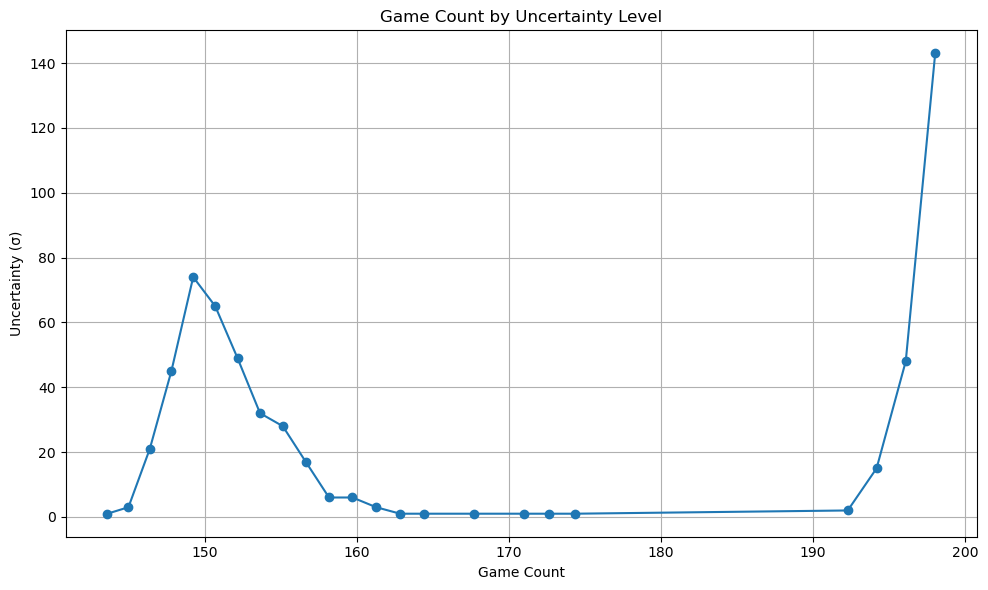

In [115]:
import matplotlib.pyplot as plt

# Group by uncertainty and count occurrences
uncertainty_counts = elo_updated_df['uncertainty'].value_counts().sort_index()

# Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(uncertainty_counts.index, uncertainty_counts.values, marker='o', linestyle='-')
plt.ylabel('Uncertainty (σ)')
plt.xlabel('Game Count')
plt.title('Game Count by Uncertainty Level')
plt.grid(True)
plt.tight_layout()
plt.show()